In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle, noisy_ellipses
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Topological Optimal Transport

#### Generate source and target point clouds

We generate a source point cloud as a disjoint union of 4 circles. The target point cloud is instead given by a flower with 4 ellipses as petals. 

In [2]:
# Source point cloud
np.random.seed(42)
data1 = noisy_circle(50, 0.1, 0, 0, 3 )
data2 = noisy_circle(50, 0.1, 10, 0, 3 )
data3 = noisy_circle(50, 0.1, 20, 0, 3 )
data4 = noisy_circle(50, 0.1, 30, 0, 3 )
A = np.concatenate([data1, data2, data3, data4])

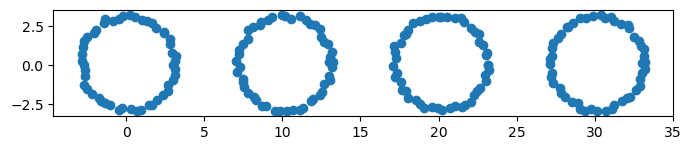

In [3]:
plt.scatter(A[:,0],A[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
# Target point cloud
np.random.seed(42)
data1 = noisy_ellipses(50, 0.1, 3, 8, 0, 0 )
data2 = noisy_ellipses(50, 0.1, 3, 8, 0, -16)
data3 = noisy_ellipses(50, 0.1, 8, 3, -9, -8)
data4 = noisy_ellipses(50, 0.1, 8, 3, 9, -8)
B = np.concatenate([data1, data2, data3, data4])

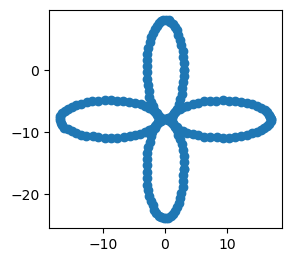

In [5]:
plt.figure(figsize = (3, 3))
plt.scatter(B[:,0],B[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
# Compute pairwise distance matrices for source A and target B
# C1 = sp.spatial.distance.cdist(A, A, "euclidean"); C1 /= np.mean(C1)
# C2 = sp.spatial.distance.cdist(B, B, "euclidean"); C2 /= np.mean(C2)
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
# Compute GW matching between source A and target B
p = ot.unif(len(A))
q = ot.unif(len(B))
gw0, log0 = ot.gromov.gromov_wasserstein(
    C_v0, C_v1, p, q, 'square_loss', verbose=True, log=True)
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
Id = [t[0] for t in A]
p = np.matmul(P, Id)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.046090e-01|0.000000e+00|0.000000e+00
    1|1.355325e-01|5.096671e-01|6.907646e-02
    2|9.839919e-02|3.773742e-01|3.713332e-02
    3|5.970069e-02|6.482086e-01|3.869850e-02
    4|5.661973e-02|5.441495e-02|3.080960e-03
    5|5.651021e-02|1.938034e-03|1.095187e-04
    6|5.650876e-02|2.572373e-05|1.453616e-06
    7|5.650876e-02|0.000000e+00|0.000000e+00


In [7]:
# Construct color scale for plotting
one = topo_util.get_eigvec(A[:50])
one = one - min(one)
one = (one/max(one))/4
two = topo_util.get_eigvec(A[50:100])
two = two - min(two)
two = 0.25 + (two/max(two))/4
three = topo_util.get_eigvec(A[100:150])
three = three - min(three)
three = 0.5 + (three/max(three))/4
four = topo_util.get_eigvec(A[150:200])
four = four - min(four)
four = 0.75 + (four/max(four))/4
color_figures = np.concatenate([one,two, three,four])

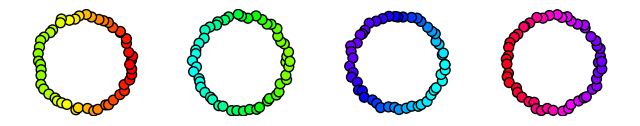

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=50,edgecolors='black', vmax=1, vmin=0, cmap = "hsv")
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/loops_source.svg')
plt.show()

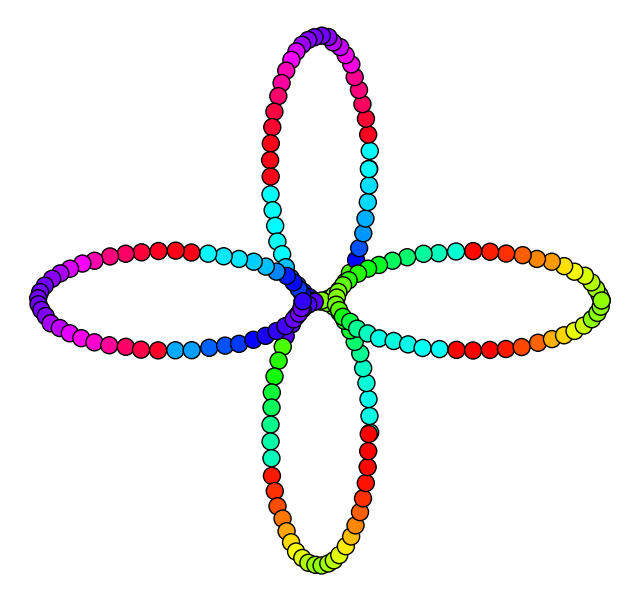

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)
plt.scatter(B[:,0],B[:,1],c = p_gromov,s=150,edgecolors='black', vmax=1, vmin=0, cmap = "hsv")
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()
plt.savefig('../outputs/loops_target_GW.svg')
plt.show()

### Compute PH and PH-hypergraph

In [10]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic   

In [11]:
# Compute 1-dimensional PH and representative cycles of each dataset. 
H_all = [PH(x) for x in tqdm([A,B])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.09s/it]


In [12]:
# Each element in H_all is a dictionary with keys 'barcode', 'representatives'
# H_all['barcode'] contains birth and death times of homology classes. H_all['representatives']   
# contains the list of indices of a representative cycle, for each homology class in barcode. 
H_all[0];

In [13]:
import ot
# Transforms barcodes in dataframes
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [14]:
# Compute the augmented Wasserstein cost matrix between target and source barcode
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)

In [15]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [16]:
# Construct PH-hypeprgraphs from H_all
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [17]:
importlib.reload(topo_util)
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

In [18]:
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1) 
y0 = y0_imputed; y1 = y1_imputed;

In [19]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd.mean()

In [20]:
alpha = 0.7
beta = 1
sys.path.append("../../hg-barycenters/src/")
importlib.reload(tpot)

v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1, 
                           C_v0, C_v1, C_pd, 
                           beta = beta, alpha = alpha, print_iter = 5, iter = 100,
                           solver = "sinkhorn", 
                           eps_s = 0.01, eps_f = 0.01, numItermax = 1000)

Iteration 0,	 obj = 0.10112782116935527,	 obj_terms = {'coot': 0.03675006681981256, 'ot': 0.0056447455282583586, 'gw': 0.05873300882128435}
Iteration 5,	 obj = 0.06548429573668654,	 obj_terms = {'coot': 0.01919994052552136, 'ot': 0.005637942824878723, 'gw': 0.040646412386286454}
Iteration 10,	 obj = 0.05324273754485352,	 obj_terms = {'coot': 0.00833875926394571, 'ot': 0.005636886942856784, 'gw': 0.03926709133805102}
Iteration 15,	 obj = 0.05326428154773171,	 obj_terms = {'coot': 0.008310631536046347, 'ot': 0.005636886945528177, 'gw': 0.03931676306615719}
Iteration 20,	 obj = 0.05326442589861266,	 obj_terms = {'coot': 0.008310445660670799, 'ot': 0.0056368869455620755, 'gw': 0.03931709329237979}
Iteration 25,	 obj = 0.05326443695626861,	 obj_terms = {'coot': 0.008310445132795897, 'ot': 0.005636886945563205, 'gw': 0.03931710487790951}
is_converged, obj = 0.05326443695626861, obj_new = 0.05326443770296017


In [21]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q[np.isnan(Q)] = 0

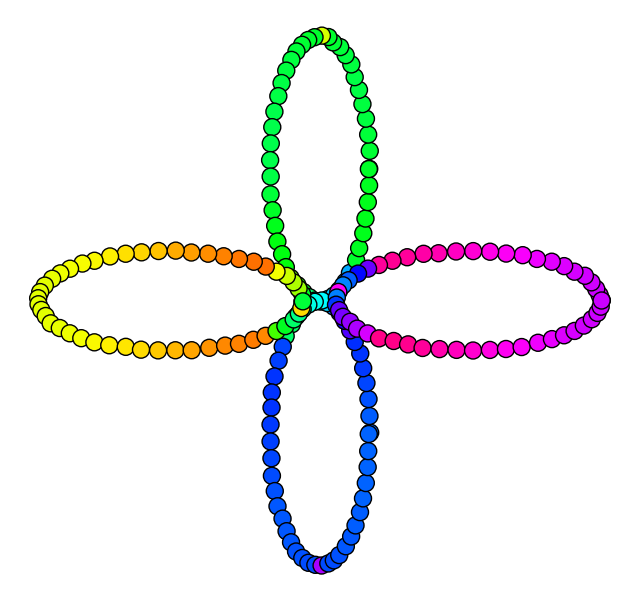

In [22]:
color_target  = np.matmul(P.T, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

plt.scatter(B[:,0],B[:,1],c = color_target,s=150,edgecolors='black', vmax=1, vmin=0, cmap = "hsv")
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()

plt.savefig('../outputs/loops_target_tpot_alpha{}_beta{}.svg'.format(alpha,beta))

plt.show()

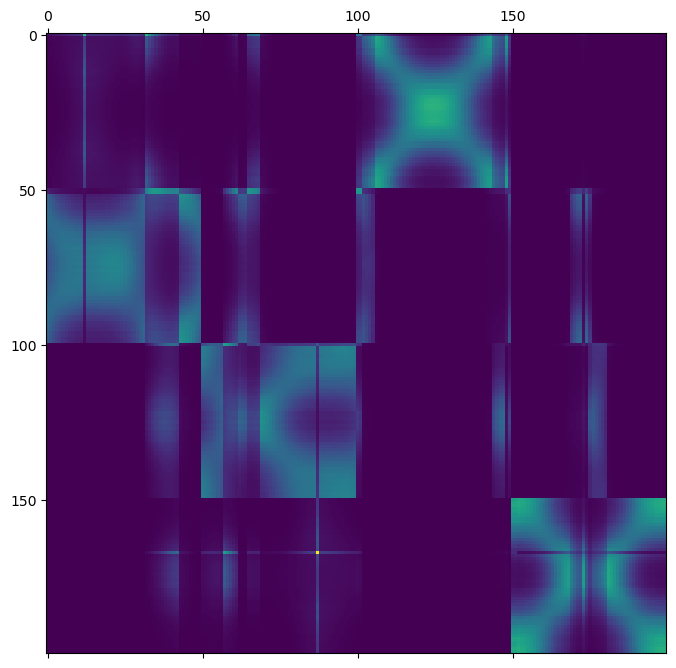

In [23]:
plt.matshow(P)

In [24]:
# Find geodesic
matching = np.array(np.where(ot.emd(w0, w1, pi_s.max()-pi_s) > 0)).T # round coupling
def geodesic_distances(a,b,t,indices):
    #Compute pairwise distance between points in geodesic
    N = len(indices)
    M = np.zeros((N, N))
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        for jj in range(ii+1, N):
            Pj = a[indices[jj][0]]
            Qj = b[indices[jj][1]]
            
            Pj = np.array(Pj)
            Qj = np.array(Qj)
            da = np.linalg.norm(Pi - Pj)
            db = np.linalg.norm(Qi - Qj)
            M[ii][jj] = t* da + (1-t)*db
    return M + M.T 

def convex_point(a,b,t,indices):
    N = len(indices)
    v = []
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        v.append( Pi*t + Qi*(1-t))
    return v

In [25]:
num_frames = 100
x1 = np.linspace(0, 1, num_frames, endpoint=True)
matrices = [geodesic_distances(A,B,t, matching) for t in x1]
convex_points = np.array([convex_point(A,B,t, matching) for t in x1])

In [26]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances

model = MDS(n_components=2, dissimilarity='precomputed', random_state=2002)

In [27]:
from scipy.spatial.transform import Rotation as R
def align(AA,BB):
    AA = [[aa[0], aa[1], 0] for aa in AA]
    BB = [[aa[0], aa[1], 0] for aa in BB]
    rot, rssd, sens = R.align_vectors(BB, AA, return_sensitivity=True)
    return rot.apply(AA)[:,:2]
def reflect(a):
    return np.array([ [aa[0], -aa[1]] for aa in a ])

In [28]:
import warnings
warnings.filterwarnings("ignore")
models = []
out = model.fit(matrices[0]).embedding_
pos = align(out, convex_points[0])
models_alligned = [pos]
for ii in range(1, num_frames):
    true = convex_points[ii]
    out = model.fit(matrices[ii]).embedding_
    pos = align(out, true)
    rpos = reflect(pos)
    if np.linalg.norm(models_alligned[-1] - pos) >  np.linalg.norm(models_alligned[-1] - rpos):
        pos = rpos
    models.append(out)
    models_alligned.append(pos)

In [29]:
frames = []
for i in range(0, num_frames):
    df = pandas.DataFrame()
    df['x'] = list(np.array(models_alligned[i]).T[0])
    df['y'] = list(np.array(models_alligned[i]).T[1])
    df['frame'] = i
    df['color'] = np.concatenate([[0 for jj in range(50)],[0.33 for jj in range(50)],[0.66 for jj in range(50)],[1 for jj in range(50)]])
    frames.append(df)

DF = pandas.concat(frames)
DF['size'] = 30

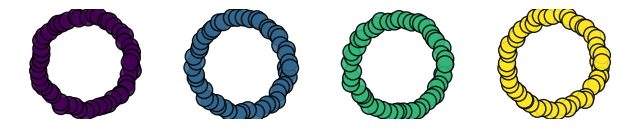

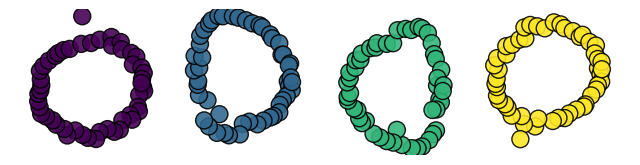

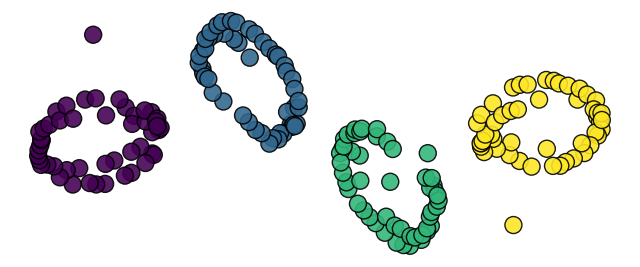

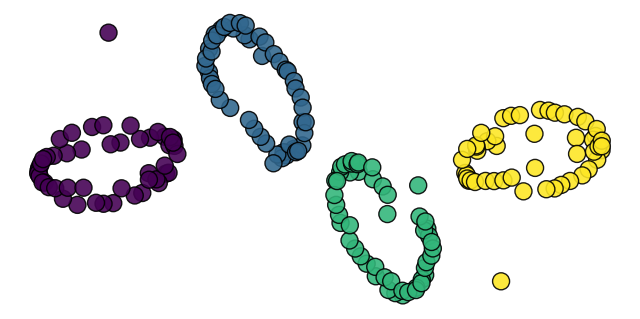

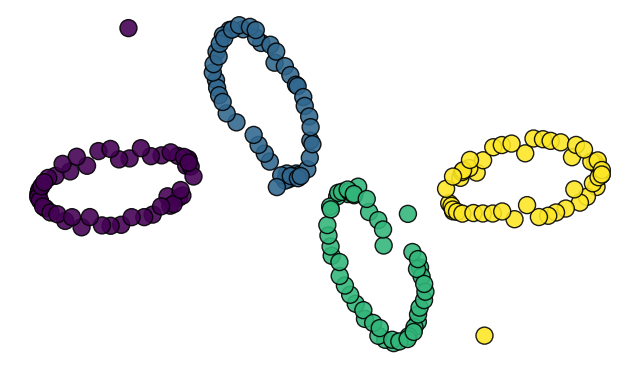

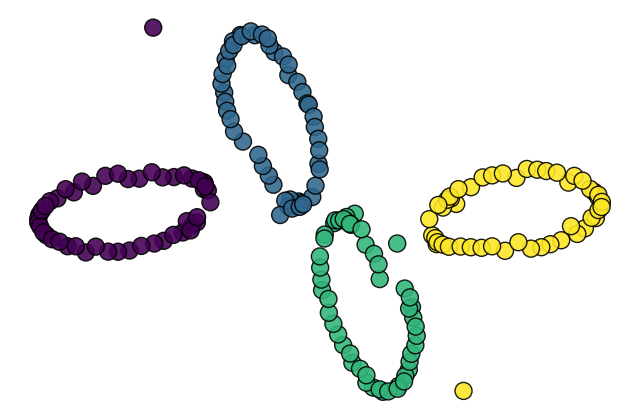

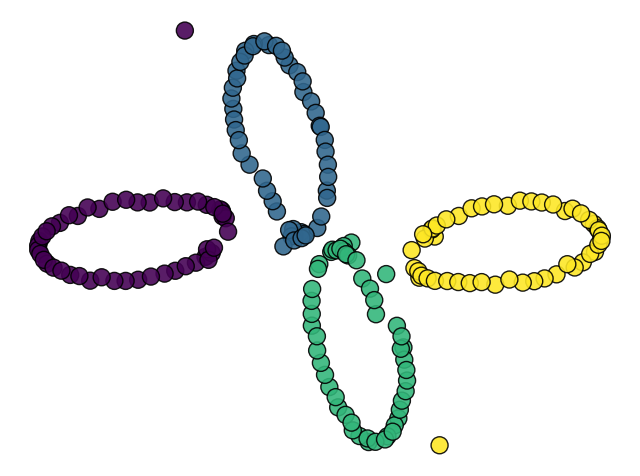

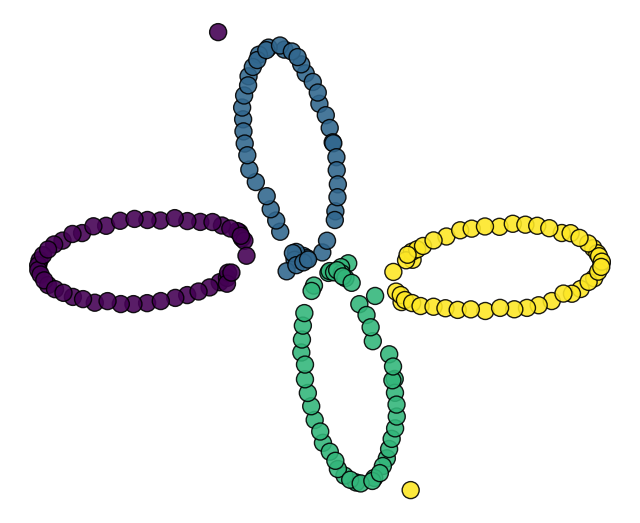

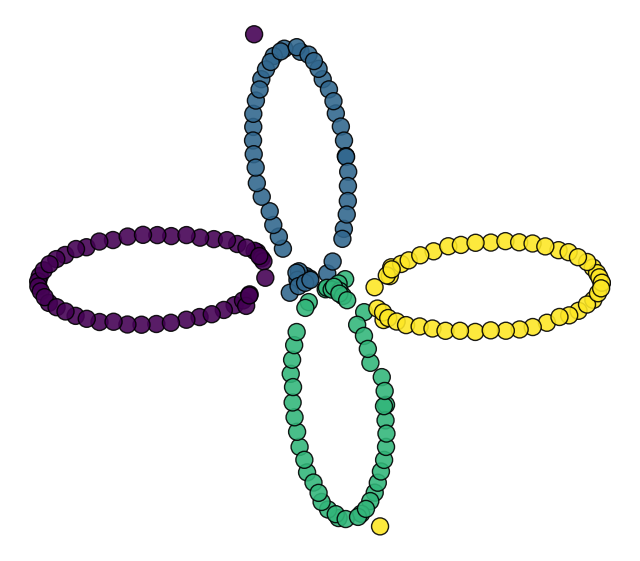

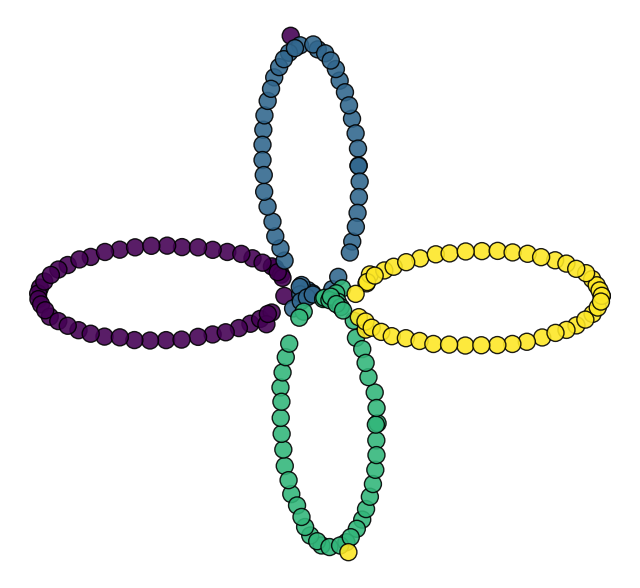

In [30]:
import matplotlib.animation as animation
N = 200 # number of points 
for j in np.arange(num_frames, step = 10):
    i = 99 -j
    fig = plt.figure()
    ax = fig.add_subplot()
    scat = ax.scatter(DF['x'][i*N:N*(1+i)], DF['y'][i*N:N*(1+i)], 
                      marker='o', 
                      s=150,
                      c = DF['color'][i*N:N*(1+i)],
                      alpha= 0.89, edgecolors='black')
    ax.set_axis_off()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.tight_layout()
    plt.savefig('../outputs/geodesic_{}_{}_{}.svg'.format(alpha,beta,j))
    plt.show()


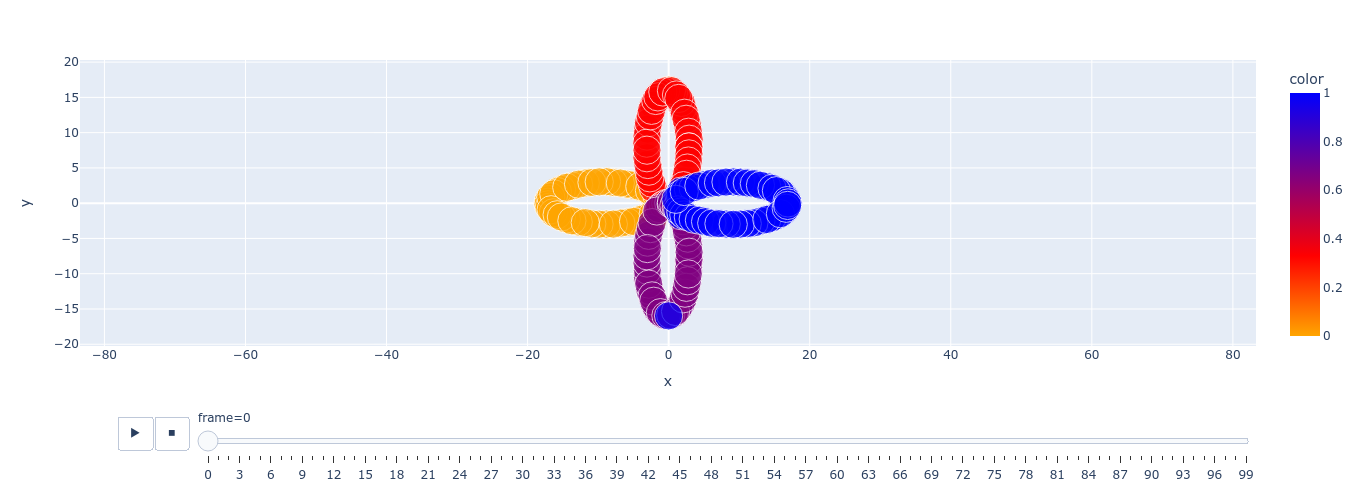

In [31]:
new_scale=[
                [0.0,'orange'],
                [0.33, 'red'],
                [0.66, 'purple'],
                [1.0, 'blue']]
df = px.data.gapminder()
fig = px.scatter(DF, x="x", y="y", animation_frame="frame",size='size', color= 'color',
                 color_continuous_scale= new_scale,
            )
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
    #plt.savefig('outputs/loops_geo_{}.png'.format(j))
    #plt.savefig('outputs/loops_geo_{}.pdf'.format(j))
fig.update_layout(
    width = 600,
    height = 500,
)
fig.show()

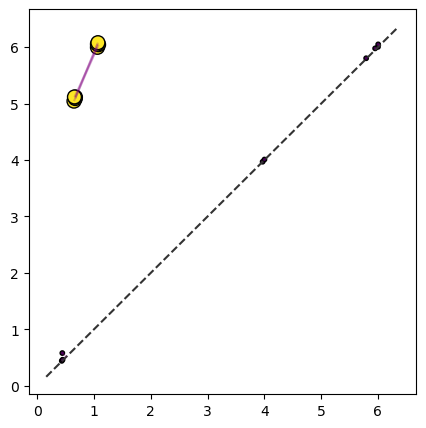

In [32]:
sizes_p = 10 + np.zeros((len(p_spt)))
sizes_q = 10 + np.zeros((len(q_spt)))
sizes_p[-1], sizes_p[-2],sizes_p[-3],sizes_p[-4] = 100,100,100,100
sizes_q[-1], sizes_q[-2],sizes_q[-3],sizes_q[-4] = 100,100,100,100

color_p =  np.ones((len(p_spt)))
color_q =  np.zeros((len(q_spt)))
color_p[-1], color_p[-2],color_p[-3],color_p[-4] = 2,2,2,2
color_q[-1], color_q[-2],color_q[-3],color_q[-4] = 3,3,3,3
plt.figure(figsize = (5, 5))
plt.subplot(1, 1, 1)
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
plt.savefig('../outputs/pds_ex1.svg', dpi=300)